<a href="https://colab.research.google.com/github/agkabir/crime-prediction/blob/main/Regression11final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Collaborators

<font color='brown'>
Md Alamgir Kabir(s193074), 
Mark Arpon Fjelsted(s127610), 
Nazer Hdaifeh (s192592)
</font>

# Install packages

In [ ]:
!pip install pyro-ppl

     |████████████████████████████████| 634kB 3.1MB/s 


# Download dataset

In [ ]:
!wget -O data.csv -nc https://data.sfgov.org/api/views/tmnf-yvry/rows.csv?accessType=DOWNLOAD

--2021-05-26 09:38:52--  https://data.sfgov.org/api/views/tmnf-yvry/rows.csv?accessType=DOWNLOAD
Resolving data.sfgov.org (data.sfgov.org)... 52.206.68.26, 52.206.140.205, 52.206.140.199
Connecting to data.sfgov.org (data.sfgov.org)|52.206.68.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘data.csv’

data.csv                [                 <=>] 525.42M  4.19MB/s    in 2m 8s   

2021-05-26 09:41:01 (4.11 MB/s) - ‘data.csv’ saved [550945238]



# Import packages

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.utils import shuffle
import torch
import torch.nn as nn

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
from pyro.infer import Predictive
from pyro.nn import PyroModule, PyroSample

np.random.seed(9001)

# Read dataset

In [ ]:
df_org = pd.read_csv("data.csv")
df_org.head()

,PdId,IncidntNum,Incident Code,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,location,SF Find Neighborhoods 2 2,Current Police Districts 2 2,Current Supervisor Districts 2 2,Analysis Neighborhoods 2 2,DELETE - Fire Prevention Districts 2 2,DELETE - Police Districts 2 2,DELETE - Supervisor Districts 2 2,DELETE - Zip Codes 2 2,DELETE - Neighborhoods 2 2,DELETE - 2017 Fix It Zones 2 2,Civic Center Harm Reduction Project Boundary 2 2,Fix It Zones as of 2017-11-06 2 2,DELETE - HSOC Zones 2 2,Fix It Zones as of 2018-02-07 2 2,"CBD, BID and GBD Boundaries as of 2017 2 2","Areas of Vulnerability, 2016 2 2",Central Market/Tenderloin Boundary 2 2,Central Market/Tenderloin Boundary Polygon - Updated 2 2,HSOC Zones as of 2018-06-05 2 2,OWED Public Spaces 2 2,Neighborhoods 2
0,3114751606302,31147516,6302,LARCENY/THEFT,PETTY THEFT FROM A BUILDING,Sunday,09/28/2003,10:00,SOUTHERN,NONE,1ST ST / BRANNAN ST,-120.500000,90.000000,POINT (-120.50000000000001 90),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5069701104134,50697011,4134,ASSAULT,BATTERY,Wednesday,06/22/2005,12:20,NORTHERN,NONE,1200 Block of EDDY ST,-122.428223,37.781896,POINT (-122.42822330317601 37.7818959488603),97.0,4.0,11.0,39.0,7.0,9.0,11.0,29490.0,41.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,97.0
2,6074729204104,60747292,4104,ASSAULT,ASSAULT,Saturday,07/15/2006,00:55,CENTRAL,NONE,1600 Block of POWELL ST,-122.410672,37.799789,POINT (-122.41067242533701 37.799788690123),106.0,6.0,3.0,6.0,3.0,1.0,10.0,308.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,106.0
3,7103536315201,71035363,15201,ASSAULT,STALKING,Tuesday,09/25/2007,00:01,TARAVAL,NONE,400 Block of ULLOA ST,-122.458226,37.741362,POINT (-122.458226300605 37.7413616001449),49.0,10.0,8.0,41.0,1.0,8.0,4.0,59.0,40.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,49.0
4,11082415274000,110824152,74000,MISSING PERSON,MISSING ADULT,Saturday,09/24/2011,11:00,TARAVAL,LOCATED,3200 Block of SAN JOSE AV,-122.459173,37.708200,POINT (-122.459172646607 37.7082001648459),NaN,NaN,NaN,NaN,NaN,NaN,NaN,28588.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Manipulate dataset

In [ ]:
df = df_org.copy()[[
    "PdDistrict",
    "Date",
    "Time",
    "Category"
]]
df.dropna(inplace=True)

# Pick out crime categories: LARCENY/THEFT, ASSAULT, VEHICLE THEFT, BURGLARY
crime_cat = df.groupby("Category").count()["PdDistrict"].sort_values(ascending=False).iloc[[0,3,4,8]]

# Number of crime categories
n_crime = 4
print(crime_cat)

# List of chosen categories
crime_cat_list = list(crime_cat.index)

# Encoded values for categories
crime_cat_enc = list(range(0,n_crime))

# Get number of entries before modifying
count = df.shape[0]

# Filter out unwanted categories
df = df[df.Category.isin(crime_cat_list)]

# Encode categories into a numerical value
df.replace(crime_cat_list, crime_cat_enc, inplace=True)

# Get difference in element count
diff = count-df.shape[0]
print("Removed %d entries\n" % diff)

df

Category
LARCENY/THEFT    477974
ASSAULT          167042
VEHICLE THEFT    126228
BURGLARY          91067
Name: PdDistrict, dtype: int64
Removed 1267213 entries



,PdDistrict,Date,Time,Category
0,SOUTHERN,09/28/2003,10:00,0
1,NORTHERN,06/22/2005,12:20,1
2,CENTRAL,07/15/2006,00:55,1
3,TARAVAL,09/25/2007,00:01,1
5,SOUTHERN,12/12/2003,12:00,1
...,...,...,...,...
2129502,NORTHERN,02/03/2018,23:45,0
2129510,RICHMOND,05/20/2017,14:30,0
2129511,TENDERLOIN,11/21/2017,18:00,1
2129520,NORTHERN,12/01/2016,17:30,3


In [ ]:
# Get a datetime series
dt = pd.to_datetime(df["Date"]+" "+df["Time"], format="%m/%d/%Y %H:%M").dt

# Drop old date and time columns
df.drop(columns=["Date","Time"], inplace=True)

# Add new date and time columns
new_paras = [dt.year,dt.month,dt.isocalendar().week,dt.hour]
labels = ["Year","Month","Week","Hour"]
df = df.join(pd.concat(new_paras, axis=1, keys=labels))

# Filter years
df = df[(df["Year"] >= 2010)]

# Convert hours into shifts
def get_shift(hour):
    if 8 <= hour <= 15:
        return "Morning"
    elif 16 <= hour <= 23:
        return "Evening"
    else:
        return "Night"
df = df.assign(Shift=lambda x: x["Hour"].apply(get_shift))
df.drop(columns=["Hour"], inplace=True)

df

,PdDistrict,Category,Year,Month,Week,Shift
7,MISSION,3,2016,2,5,Evening
8,TARAVAL,0,2017,1,3,Evening
9,TARAVAL,0,2016,8,32,Evening
11,RICHMOND,0,2017,5,20,Morning
12,SOUTHERN,0,2017,11,44,Night
...,...,...,...,...,...,...
2129502,NORTHERN,0,2018,2,5,Evening
2129510,RICHMOND,0,2017,5,20,Morning
2129511,TENDERLOIN,1,2017,11,47,Evening
2129520,NORTHERN,3,2016,12,48,Evening


In [ ]:
# Aggregate identical rows (new column is "size")
df = df.groupby(df.columns.tolist(), as_index=False).size()

# Rename column
df.rename(columns={"size":"Count"}, inplace=True)

# Remove distinctions between years, months and weeks
df.drop(columns=["Year","Month","Week"], inplace=True)

# Resulting rows each represent 1 week of crime records
# For example, row 0 tells us that 12 crimes of category 0
# happened in BAYVIEW during Evening shifts
df

,PdDistrict,Category,Shift,Count
0,BAYVIEW,0,Evening,12
1,BAYVIEW,0,Morning,14
2,BAYVIEW,0,Night,4
3,BAYVIEW,0,Evening,20
4,BAYVIEW,0,Morning,14
...,...,...,...,...
55465,TENDERLOIN,3,Evening,2
55466,TENDERLOIN,3,Morning,1
55467,TENDERLOIN,3,Evening,2
55468,TENDERLOIN,3,Morning,2


In [ ]:
# One-hot encode feature columns
df = pd.get_dummies(df, columns=["PdDistrict","Shift"])
df

,Category,Count,PdDistrict_BAYVIEW,PdDistrict_CENTRAL,PdDistrict_INGLESIDE,PdDistrict_MISSION,PdDistrict_NORTHERN,PdDistrict_PARK,PdDistrict_RICHMOND,PdDistrict_SOUTHERN,PdDistrict_TARAVAL,PdDistrict_TENDERLOIN,Shift_Evening,Shift_Morning,Shift_Night
0,0,12,1,0,0,0,0,0,0,0,0,0,1,0,0
1,0,14,1,0,0,0,0,0,0,0,0,0,0,1,0
2,0,4,1,0,0,0,0,0,0,0,0,0,0,0,1
3,0,20,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0,14,1,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55465,3,2,0,0,0,0,0,0,0,0,0,1,1,0,0
55466,3,1,0,0,0,0,0,0,0,0,0,1,0,1,0
55467,3,2,0,0,0,0,0,0,0,0,0,1,1,0,0
55468,3,2,0,0,0,0,0,0,0,0,0,1,0,1,0


In [ ]:
import seaborn as sns

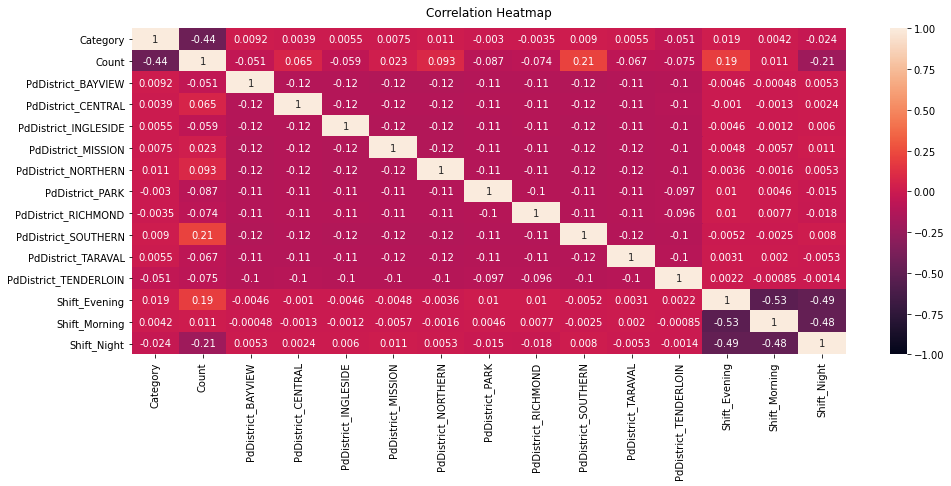

In [ ]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

# Prepare model data

In [ ]:
# Split data into features and target values
X = df.drop(columns=["Category","Count"]).values
y = df["Count"].values

# List of crime categories corresponding to X and y
crime_cat = df["Category"].values

# Number of features
n_feats = X.shape[1]
# Number of crime categories
n_crime = n_crime

# Split into training and test data sets
train_perc = 0.60 # percentage of training data
split_point = int(train_perc*len(y))
perm = np.random.permutation(len(y))
ix_train = perm[:split_point]
ix_test = perm[split_point:]

X_train = X[ix_train,:]
X_test = X[ix_test,:]

crime_cat_train = crime_cat[ix_train]
crime_cat_test = crime_cat[ix_test]

y_train = y[ix_train]

y_test = y[ix_test]

print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

# Prepare data for Pyro model
X_train_torch = torch.tensor(X_train).float()
y_train_torch = torch.tensor(y_train).float()

# Method for comparing predicted and true values
def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

num train: 33282
num test: 22188


# Model #1: Initial model

Our dataset contains discrete values, so we choose a poisson distribution for the likelihood of our target values (y). For the prior (beta) we use a gamma distribution, because this is the conjugate prior to a poisson distribution. It will not necessary be the best choice, but it is beneficial for the poisson because it only contains positive values.

Each crime category will have its own set of beta values. We assume that the crime categories are of such different nature, that they cannot be modeled well with one set of beta values. Essentially, this means we have four different regression models contained within one model.

To prevent overfitting, we draw inspiration from the hierarchical models by introducing hyperpriors for the different betas.

In [ ]:
def model(X, crime_cat, n_crime, n_feats, obs=None):
    beta_alpha  = pyro.sample("beta_alpha",  dist.HalfCauchy(torch.ones(n_feats)).to_event())
    beta_beta  = pyro.sample("beta_beta",  dist.HalfCauchy(torch.ones(n_feats)).to_event())
    with pyro.plate("crime", n_crime):
        beta  = pyro.sample("beta", dist.Gamma(beta_alpha, beta_beta).to_event())
    with pyro.plate("data", X.shape[0]):
        # We multiply each row of features with its corresponding beta values depending on the crime
        # This will essentially be the diagonal of the resulting matrix product
        prod_diag = torch.einsum("ij,ij->i", X, beta[crime_cat])
        y = pyro.sample("y", dist.Poisson(prod_diag), obs=obs)
    return y

In [ ]:
# Define guide function
guide = AutoDiagonalNormal(model)
# Define the number of optimization steps
n_steps = 10000
# Setup the inference algorithm
pyro.clear_param_store()
svi = SVI(model, guide, ClippedAdam({"lr": 0.001}), Trace_ELBO())

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_torch, crime_cat_train, n_crime, n_feats, y_train_torch)
    if step == 0 or (step+1) % 2500 == 0:
        print("[%d] ELBO: %.1f" % (step+1, elbo))

[1] ELBO: 461941.3
[2500] ELBO: 135014.0
[5000] ELBO: 109471.7
[7500] ELBO: 109446.8
[10000] ELBO: 109449.1


In [ ]:
predictive = Predictive(model, guide=guide, num_samples=1000,return_sites=("beta", "beta_alpha", "beta_beta"))
samples = predictive(X_train_torch, crime_cat_train, n_crime, n_feats)

In [ ]:
beta_alpha_samples = samples["beta_alpha"].detach().numpy()
beta_beta_samples = samples["beta_beta"].detach().numpy()
beta_samples = samples["beta"].detach().numpy()

# Test for overfitting by first assessing error on training data
prod_diag = np.einsum("ij,kij->ik", X_train, beta_samples[:,crime_cat_train,:], optimize=True)
y_hat = np.mean(prod_diag, axis=1)

err_1 = compute_error(y_train, y_hat)

# Now assess error on test data
prod_diag = np.einsum("ij,kij->ik", X_test, beta_samples[:,crime_cat_test,:], optimize=True)
y_hat = np.mean(prod_diag, axis=1)

err_2 = compute_error(y_test, y_hat)

pd.DataFrame(np.round([err_1, err_2], 2), ["Training set", "Test set"], ["CorrCoef", "MAE", "RAE", "RMSE", "R2"])

,CorrCoef,MAE,RAE,RMSE,R2
Training set,0.79,4.14,0.56,7.96,0.63
Test set,0.79,4.19,0.57,8.10,0.61


We observe a small difference between error measures for training and test sets, which suggests that there is no problem with overfitting.

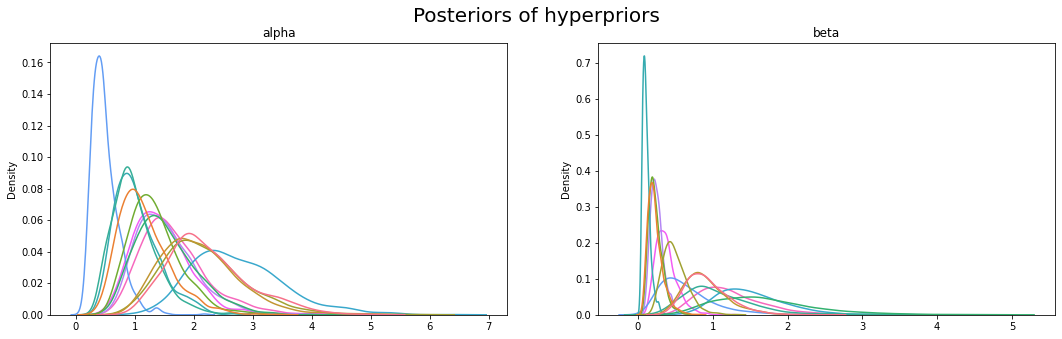

In [ ]:
fig = plt.figure(figsize=(18, 5))
fig.suptitle("Posteriors of hyperpriors", fontsize=20)

plotdata = pd.DataFrame(beta_alpha_samples[:,0,:])
ax = fig.add_subplot(1,2,1)
ax.set_title("alpha")
sns.kdeplot(ax=ax, data=plotdata,legend=False)

plotdata = pd.DataFrame(beta_beta_samples[:,0,:])
ax = fig.add_subplot(1,2,2)
ax.set_title("beta")
sns.kdeplot(ax=ax, data=plotdata,legend=False)

plt.show()

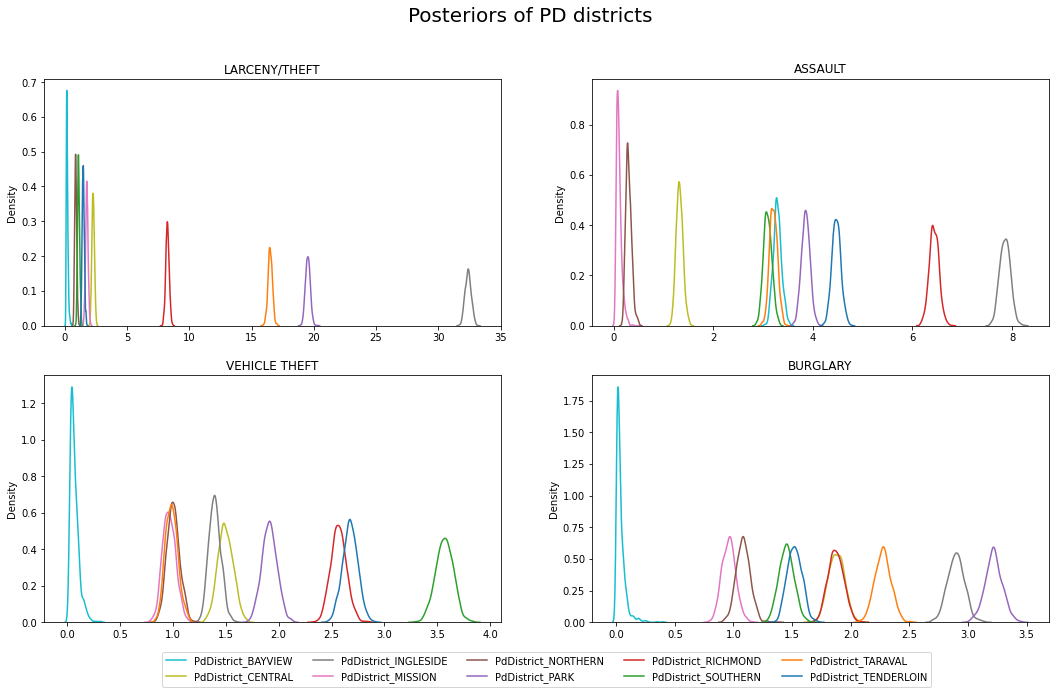

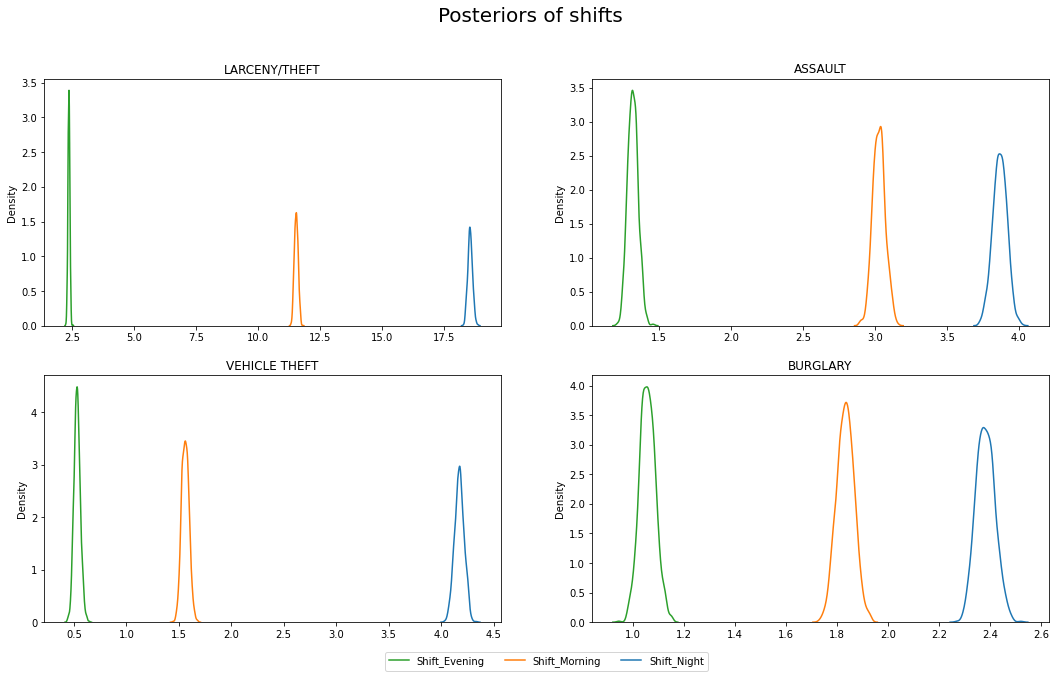

In [ ]:
def plot_pred_post(title, col_subset):
    fig = plt.figure(figsize=(18,10))
    fig.suptitle(title, fontsize=20)
    columns = df.drop(columns=["Category","Count"]).columns[col_subset]
    for c in range(n_crime):
        plotdata = pd.DataFrame(beta_samples[:,c,col_subset],columns=columns)
        ax = fig.add_subplot(2,2,c+1)
        ax.set_title(crime_cat_list[c])
        sns.kdeplot(ax=ax, data=plotdata,legend=False)
    plt.legend(columns, ncol=5, bbox_to_anchor=(-0.1, -0.1), loc="upper center")
    plt.show()

plot_pred_post("Posteriors of PD districts", range(0,10)) # PdDistricts
print()
plot_pred_post("Posteriors of shifts", range(10, 13)) # Shifts

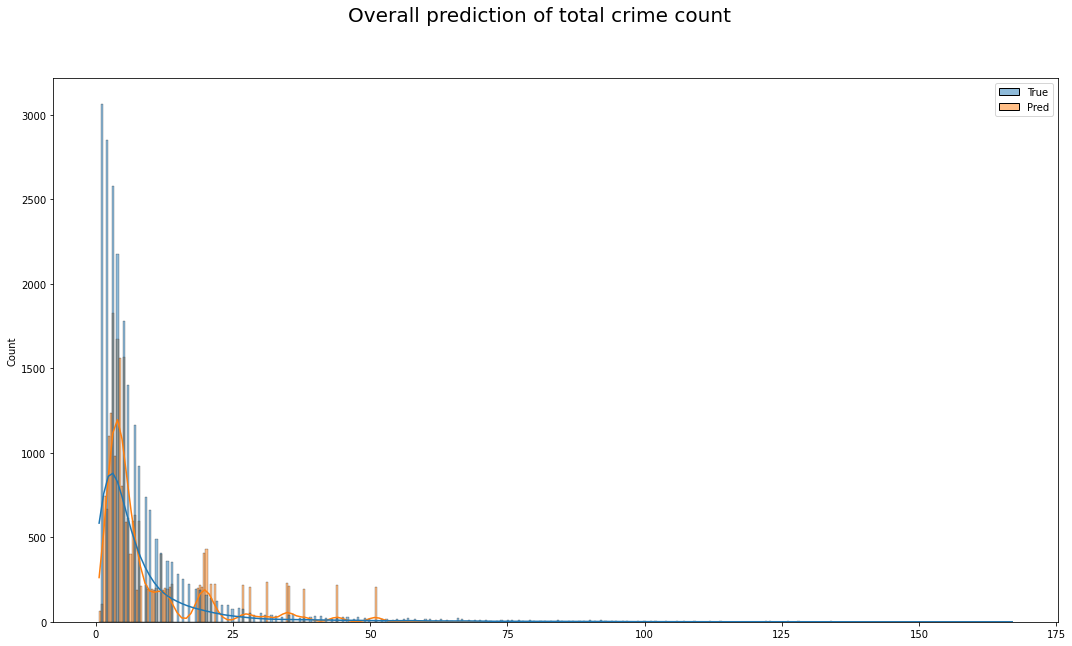

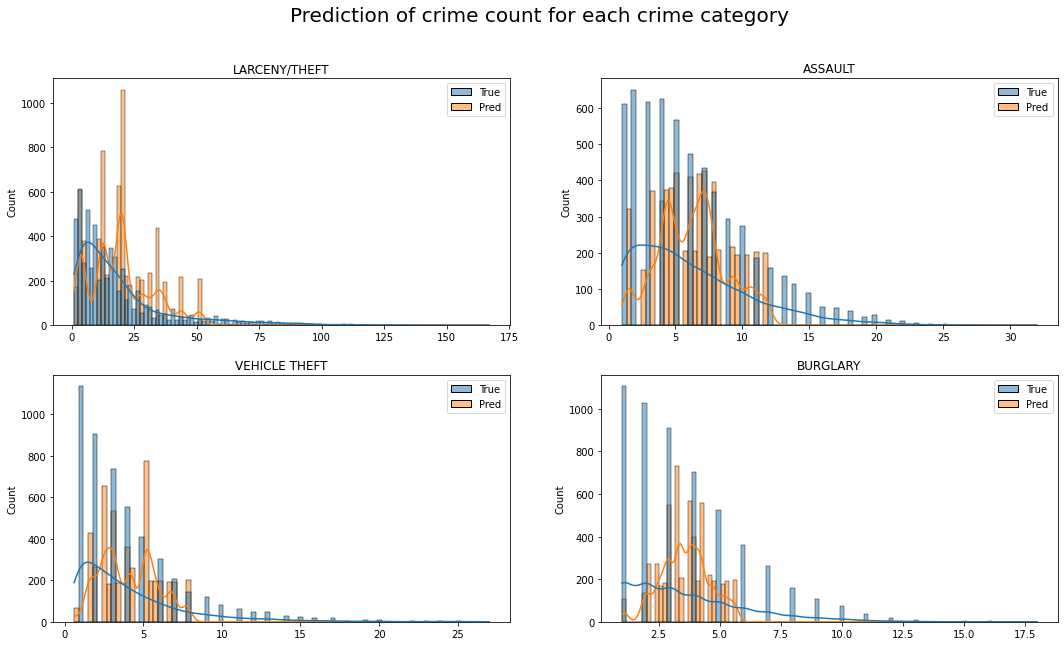

In [ ]:
r = np.matrix([y_test,y_hat]).T
r = pd.DataFrame(r, columns=["True", "Pred"])

fig,ax = plt.subplots(figsize=(18, 10))
fig.suptitle("Overall prediction of total crime count", fontsize=20)
sns.histplot(ax=ax, data=r, kde=True)
plt.show()

fig = plt.figure(figsize=(18, 10))
fig.suptitle("Prediction of crime count for each crime category", fontsize=20)
for c in range(n_crime):
    plotdata = r[crime_cat_test == c]
    ax = fig.add_subplot(2,2,c+1)
    ax.set_title(crime_cat_list[c])
    sns.histplot(ax=ax, data=plotdata, kde=True)
plt.show()

The results of the model are adequate. Judging from the predicted distribution of the crime count and by looking at the error measures, it seems the model is able to reproduce a rough pattern of the crime counts from our limited features.

A curious observation are the posteriors of the hyperpriors. Several of the distributions have high variance with fat tails. The reason we used hyperpriors was an attempt to prevent overfitting. This might be an issue if each crime category has too few observations. However, posteriors observed could be an indication that overfitting is not an issue given the dataset.

# Model #2: Removing hyperpriors

We will remove the hyperpriors and build the model again.

In [ ]:
def model(X, crime_cat, n_crime, n_feats, obs=None):
    with pyro.plate("crime", n_crime):
        beta  = pyro.sample("beta", dist.Gamma(torch.ones(n_feats), torch.ones(n_feats)).to_event())
    with pyro.plate("data", X.shape[0]):
        prod_diag = torch.einsum("ij,ij->i", X, beta[crime_cat])
        y = pyro.sample("y", dist.Poisson(prod_diag), obs=obs)
    return y

In [ ]:
# Define guide function
guide = AutoDiagonalNormal(model)
# Define the number of optimization steps
n_steps = 10000
# Setup the inference algorithm
pyro.clear_param_store()
svi = SVI(model, guide, ClippedAdam({"lr": 0.001}), Trace_ELBO())

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_torch, crime_cat_train, n_crime, n_feats, y_train_torch)
    if step == 0 or (step+1) % 2500 == 0:
        print("[%d] ELBO: %.1f" % (step+1, elbo))

[1] ELBO: 532344.0
[2500] ELBO: 152587.8
[5000] ELBO: 109554.3
[7500] ELBO: 109528.5
[10000] ELBO: 109529.8


In [ ]:
predictive = Predictive(model, guide=guide, num_samples=1000,return_sites=("beta",))
samples = predictive(X_train_torch, crime_cat_train, n_crime, n_feats)

In [ ]:
beta_samples = samples["beta"].detach().numpy()

# Test for overfitting by first assessing error on training data
prod_diag = np.einsum("ij,kij->ik", X_train, beta_samples[:,crime_cat_train,:], optimize=True)
y_hat = np.mean(prod_diag, axis=1)

err_1 = compute_error(y_train, y_hat)

# Now assess error on test data
prod_diag = np.einsum("ij,kij->ik", X_test, beta_samples[:,crime_cat_test,:], optimize=True)
y_hat = np.mean(prod_diag, axis=1)

err_2 = compute_error(y_test, y_hat)

pd.DataFrame(np.round([err_1, err_2], 2), ["Training set", "Test set"], ["CorrCoef", "MAE", "RAE", "RMSE", "R2"])

,CorrCoef,MAE,RAE,RMSE,R2
Training set,0.80,4.14,0.56,7.96,0.63
Test set,0.79,4.19,0.57,8.10,0.61


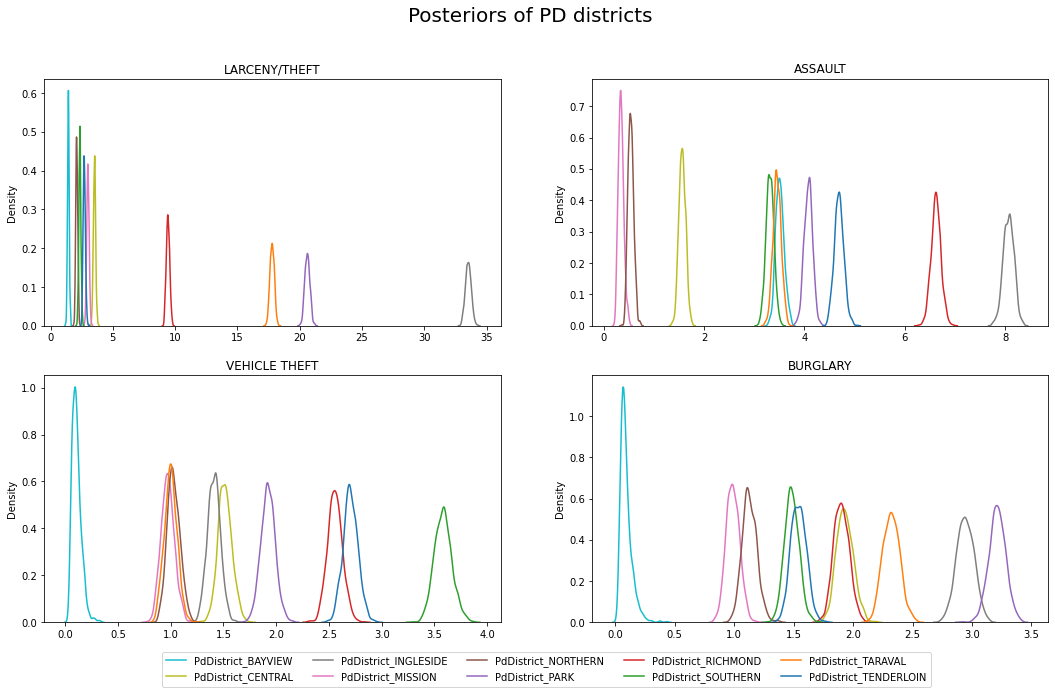

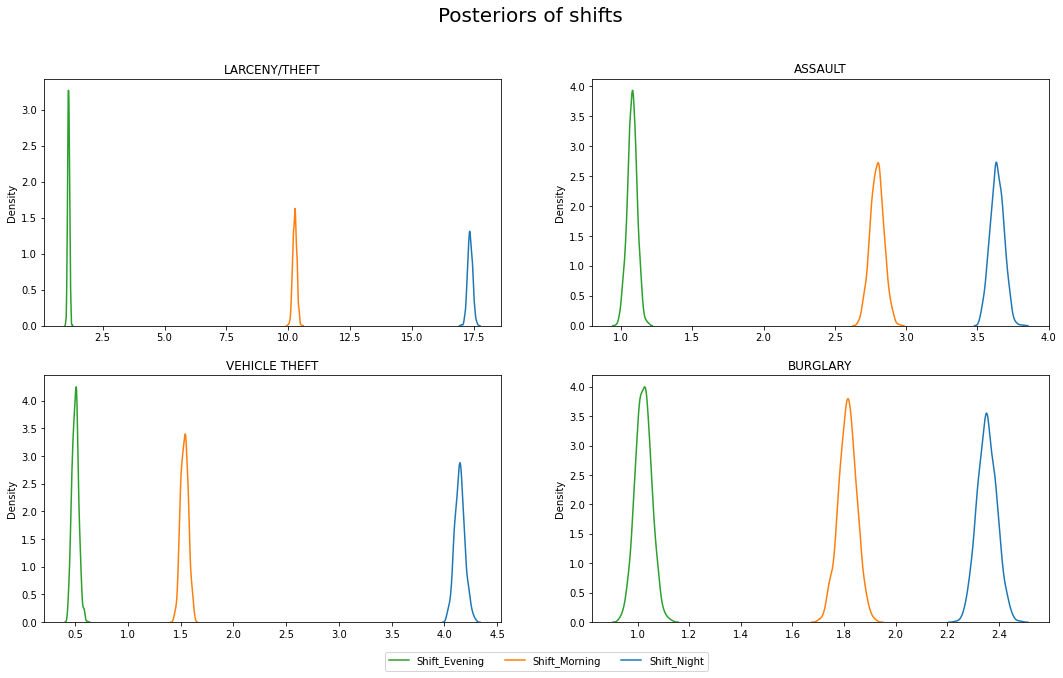

In [ ]:
def plot_pred_post(title, col_subset):
    fig = plt.figure(figsize=(18,10))
    fig.suptitle(title, fontsize=20)
    columns = df.drop(columns=["Category","Count"]).columns[col_subset]
    for c in range(n_crime):
        plotdata = pd.DataFrame(beta_samples[:,c,col_subset],columns=columns)
        ax = fig.add_subplot(2,2,c+1)
        ax.set_title(crime_cat_list[c])
        sns.kdeplot(ax=ax, data=plotdata,legend=False)
    plt.legend(columns, ncol=5, bbox_to_anchor=(-0.1, -0.1), loc="upper center")
    plt.show()

plot_pred_post("Posteriors of PD districts", range(0,10)) # PdDistricts
print()
plot_pred_post("Posteriors of shifts", range(10, 13)) # Shifts

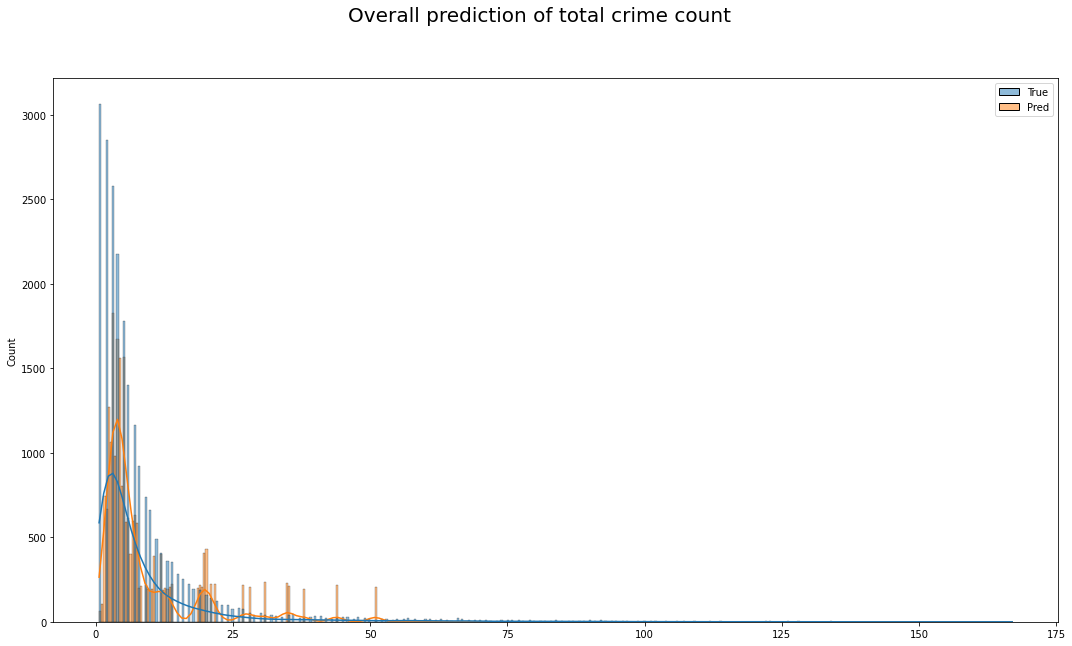

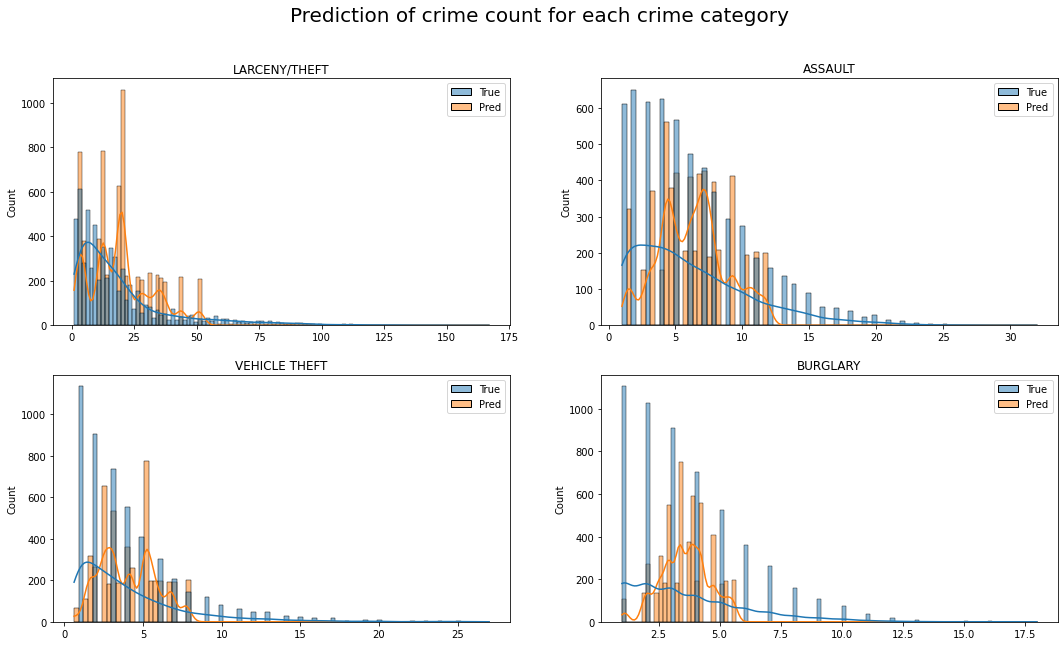

In [ ]:
r = np.matrix([y_test,y_hat]).T
r = pd.DataFrame(r, columns=["True", "Pred"])

fig,ax = plt.subplots(figsize=(18, 10))
fig.suptitle("Overall prediction of total crime count", fontsize=20)
sns.histplot(ax=ax, data=r, kde=True)
plt.show()

fig = plt.figure(figsize=(18, 10))
fig.suptitle("Prediction of crime count for each crime category", fontsize=20)
for c in range(n_crime):
    plotdata = r[crime_cat_test == c]
    ax = fig.add_subplot(2,2,c+1)
    ax.set_title(crime_cat_list[c])
    sns.histplot(ax=ax, data=plotdata, kde=True)
plt.show()

The model seems unaffected from removing the hyperpriors, so it would seem that each crime category has enough observations to prevent overfitting. Also, the R2 values remained unchanged. To prevent unnecessary complication of the model, the hyperpriors will be dropped going forward.

So far, we have used a gamma distribution for the priors for reasons explained earlier. The gamma distribution is strictly positive. It may improve the model if features were able to counteract eachother with negative values.

# Model #3: Use normal distributions for the priors

A normal distribution will allow the prior to attain both positive and negative values. Note that this will introduce a problem for the likelihood, as the poisson distribution only accepts positive values. We alleviate this problem by applying a log-link function to the priors, i.e. taking the exponential of the prior before using it in the likelihood function.

Important to keep in mind, that the problem above is not avoided completely. If large negative values are selected from the priors, the exponential function may output a zero-value due to floating point underflow. This will likely not be a problem, because we use a standard normal distribution.

In [ ]:
def model3(X, crime_cat, n_crime, n_feats, obs=None):
    with pyro.plate("crime", n_crime):
        beta = pyro.sample("beta", dist.Normal(torch.zeros(n_feats), torch.ones(n_feats)).to_event())
    with pyro.plate("data", X.shape[0]):
        prod_diag = torch.einsum("ij,ij->i", X, beta[crime_cat])
        y = pyro.sample("y", dist.Poisson(torch.exp(prod_diag)), obs=obs)
    return y

In [ ]:
# Define guide function
guide = AutoDiagonalNormal(model3)
# Define the number of optimization steps
n_steps = 10000
# Setup the inference algorithm
pyro.clear_param_store()
svi = SVI(model3, guide, ClippedAdam({"lr": 0.001}), Trace_ELBO())

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_torch, crime_cat_train, n_crime, n_feats, y_train_torch)
    if step == 0 or (step+1) % 2500 == 0:
        print("[%d] ELBO: %.1f" % (step+1, elbo))

[1] ELBO: 667523.8
[2500] ELBO: 102954.0
[5000] ELBO: 102018.5
[7500] ELBO: 102003.2
[10000] ELBO: 102006.8


In [ ]:
predictive3 = Predictive(model3, guide=guide, num_samples=1000,return_sites=("beta",))
samples3 = predictive3(X_train_torch, crime_cat_train, n_crime, n_feats)

In [ ]:
beta_samples = samples3["beta"].detach().numpy()

# Test for overfitting by first assessing error on training data
prod_diag = np.einsum("ij,kij->ik", X_train, beta_samples[:,crime_cat_train,:], optimize=True)
y_hat = np.mean(np.exp(prod_diag), axis=1)

err_1 = compute_error(y_train, y_hat)

# Now assess error on test data
prod_diag = np.einsum("ij,kij->ik", X_test, beta_samples[:,crime_cat_test,:], optimize=True)
y_hat = np.mean(np.exp(prod_diag), axis=1)

err_2 = compute_error(y_test, y_hat)

pd.DataFrame(np.round([err_1, err_2], 2), ["Training set", "Test set"], ["CorrCoef", "MAE", "RAE", "RMSE", "R2"])

,CorrCoef,MAE,RAE,RMSE,R2
Training set,0.84,3.77,0.51,7.08,0.70
Test set,0.83,3.84,0.52,7.29,0.69


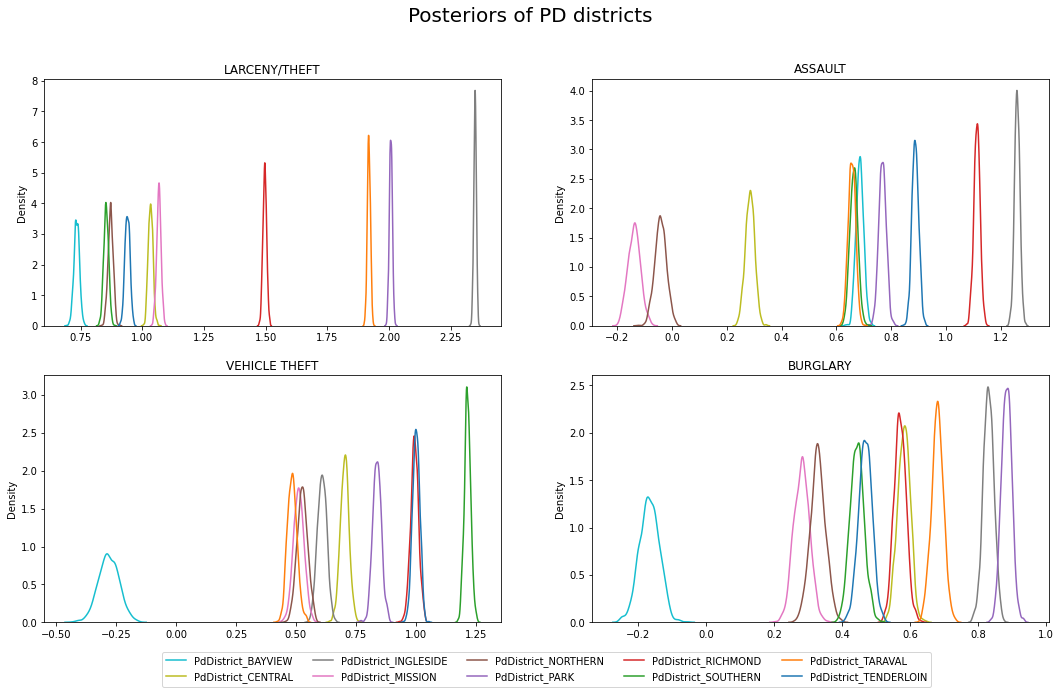

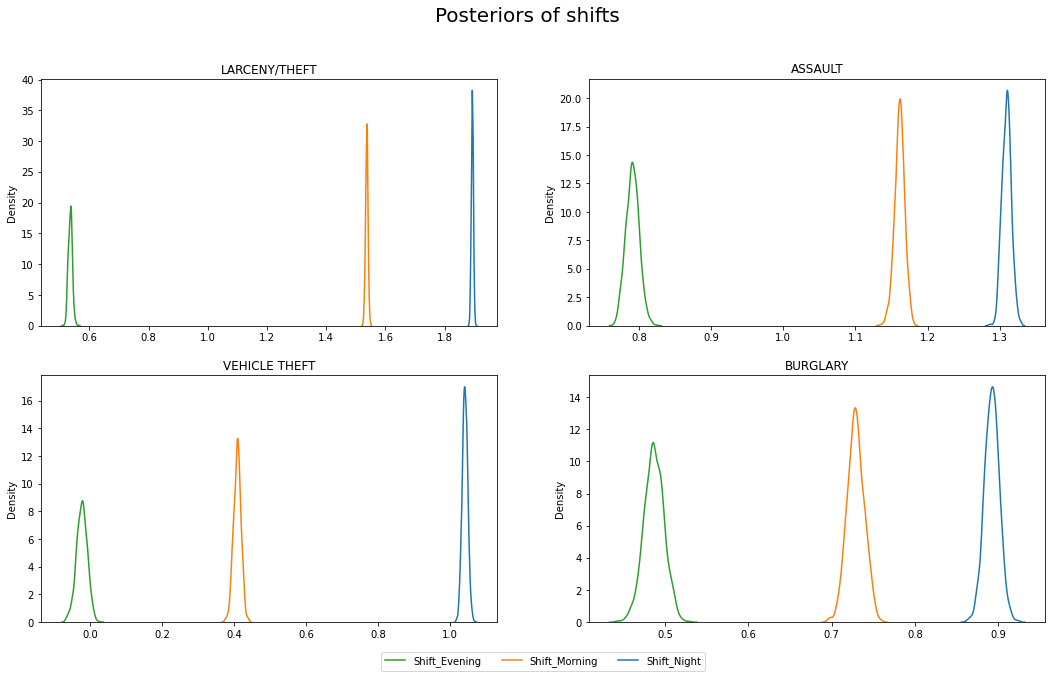

In [ ]:
def plot_pred_post(title, col_subset):
    fig = plt.figure(figsize=(18,10))
    fig.suptitle(title, fontsize=20)
    columns = df.drop(columns=["Category","Count"]).columns[col_subset]
    for c in range(n_crime):
        plotdata = pd.DataFrame(beta_samples[:,c,col_subset],columns=columns)
        ax = fig.add_subplot(2,2,c+1)
        ax.set_title(crime_cat_list[c])
        sns.kdeplot(ax=ax, data=plotdata,legend=False)
    plt.legend(columns, ncol=5, bbox_to_anchor=(-0.1, -0.1), loc="upper center")
    plt.show()

plot_pred_post("Posteriors of PD districts", range(0,10)) # PdDistricts
print()
plot_pred_post("Posteriors of shifts", range(10, 13)) # Shifts

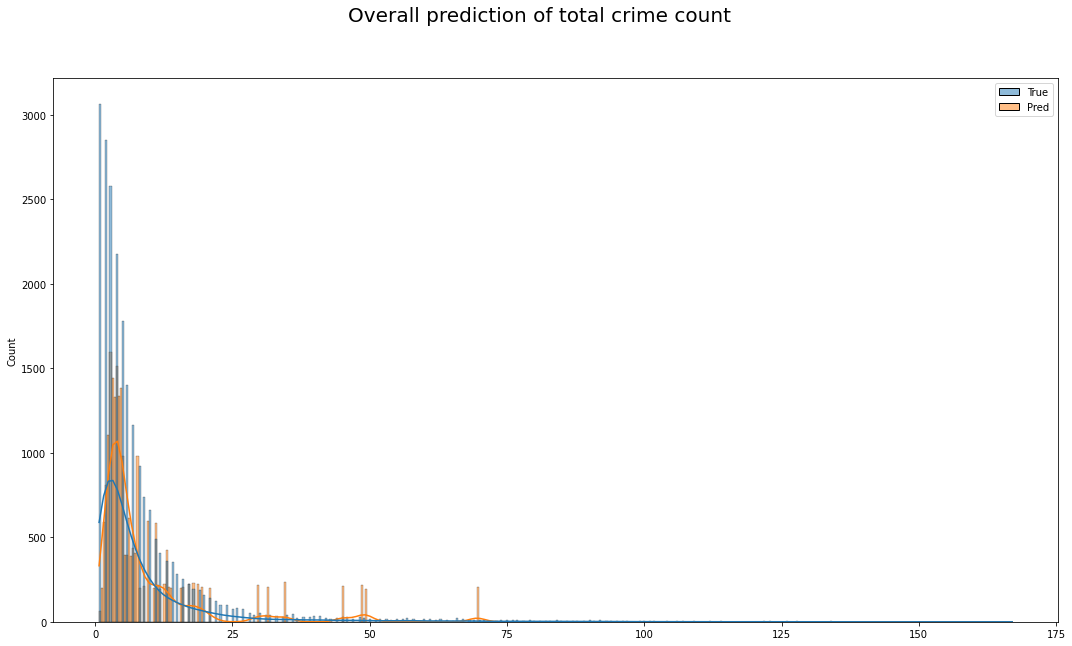

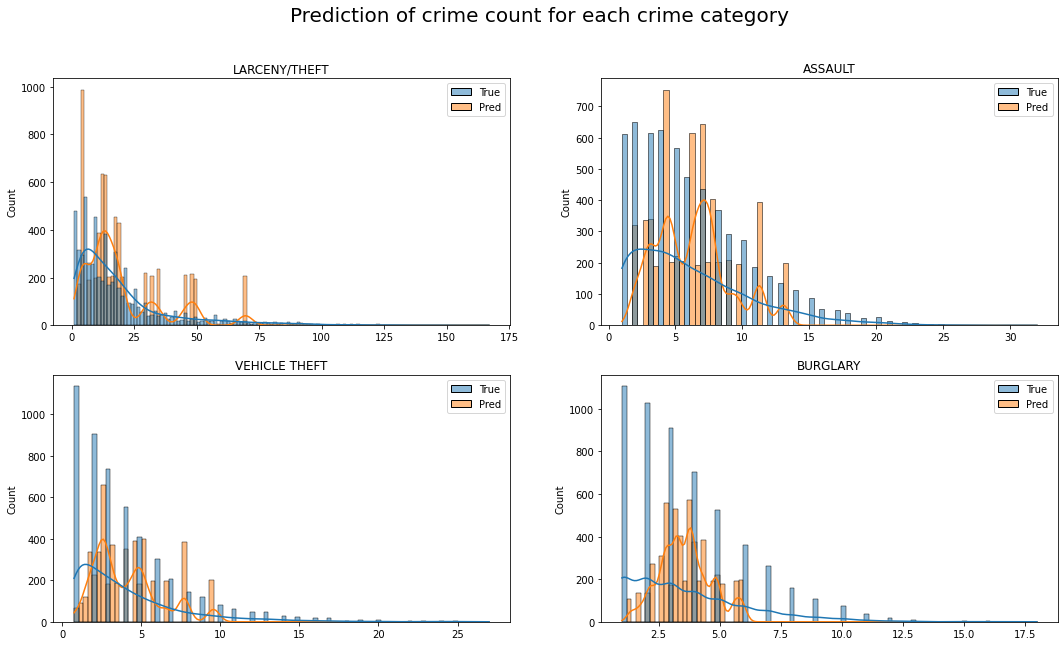

In [ ]:
r = np.matrix([y_test,y_hat]).T
r = pd.DataFrame(r, columns=["True", "Pred"])

fig,ax = plt.subplots(figsize=(18, 10))
fig.suptitle("Overall prediction of total crime count", fontsize=20)
sns.histplot(ax=ax, data=r, kde=True)
plt.show()

fig = plt.figure(figsize=(18, 10))
fig.suptitle("Prediction of crime count for each crime category", fontsize=20)
for c in range(n_crime):
    plotdata = r[crime_cat_test == c]
    ax = fig.add_subplot(2,2,c+1)
    ax.set_title(crime_cat_list[c])
    sns.histplot(ax=ax, data=plotdata, kde=True)
plt.show()

It seems the normal distribution is a better fit for the priors, because we observe a significant improvement of the error measures. Also, with the exception of BURGLARY, all individual crime categories have a visually better fitting prediction curve. And again, with the exception of BURGLARY, all posterior distributions have become much more certain, i.e. narrower.

To improve BURGLARY, we may attempt changing the likelihood function. The poisson distribution's mean is equal to the variance. Fine tuning may be necessary.

# Model #4: Change likelihood function to negative binomial

The generalization of the poisson distribution is the negative binomial distribution. This may allow for more flexibility.

The poisson distribution is a special case of the negative binomai. The parameters are r (failures) and p (probability). If we set r=1 we should get the distribution shape we are looking for. We set p=exp(prod_diag)/(exp(prod_diag)+1) which is inspired from the special case resulting in the poisson.

In [ ]:
def model(X, crime_cat, n_crime, n_feats, obs=None):
    with pyro.plate("crime", n_crime):
        beta = pyro.sample("beta", dist.Normal(torch.zeros(n_feats), torch.ones(n_feats)).to_event())
    with pyro.plate("data", X.shape[0]):
        prod_diag = torch.einsum("ij,ij->i", X, beta[crime_cat])
        y = pyro.sample("y", dist.NegativeBinomial(1,torch.exp(prod_diag)/(torch.exp(prod_diag)+1)), obs=obs)
    return y

In [ ]:
# Define guide function
guide = AutoDiagonalNormal(model)
# Define the number of optimization steps
n_steps = 10000
# Setup the inference algorithm
pyro.clear_param_store()
svi = SVI(model, guide, ClippedAdam({"lr": 0.001}), Trace_ELBO())

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_torch, crime_cat_train, n_crime, n_feats, y_train_torch)
    if step == 0 or (step+1) % 2500 == 0:
        print("[%d] ELBO: %.1f" % (step+1, elbo))

[1] ELBO: 240072.2
[2500] ELBO: 95942.7
[5000] ELBO: 95908.0
[7500] ELBO: 95899.1
[10000] ELBO: 95905.3


In [ ]:
predictive = Predictive(model, guide=guide, num_samples=1000,return_sites=("beta",))
samples = predictive(X_train_torch, crime_cat_train, n_crime, n_feats)

In [ ]:
beta_samples = samples["beta"].detach().numpy()

# Test for overfitting by first assessing error on training data
prod_diag = np.einsum("ij,kij->ik", X_train, beta_samples[:,crime_cat_train,:], optimize=True)
r = 1
p = np.exp(prod_diag)/(np.exp(prod_diag)+1)
y_hat = np.mean(r*p/(1-p), axis=1)

err_1 = compute_error(y_train, y_hat)

# Now assess error on test data
prod_diag = np.einsum("ij,kij->ik", X_test, beta_samples[:,crime_cat_test,:], optimize=True)
r = 1
p = np.exp(prod_diag)/(np.exp(prod_diag)+1)
y_hat = np.mean(r*p/(1-p), axis=1)

err_2 = compute_error(y_test, y_hat)

pd.DataFrame(np.round([err_1, err_2], 2), ["Training set", "Test set"], ["CorrCoef", "MAE", "RAE", "RMSE", "R2"])

,CorrCoef,MAE,RAE,RMSE,R2
Training set,0.84,3.78,0.51,7.12,0.70
Test set,0.83,3.84,0.52,7.32,0.68


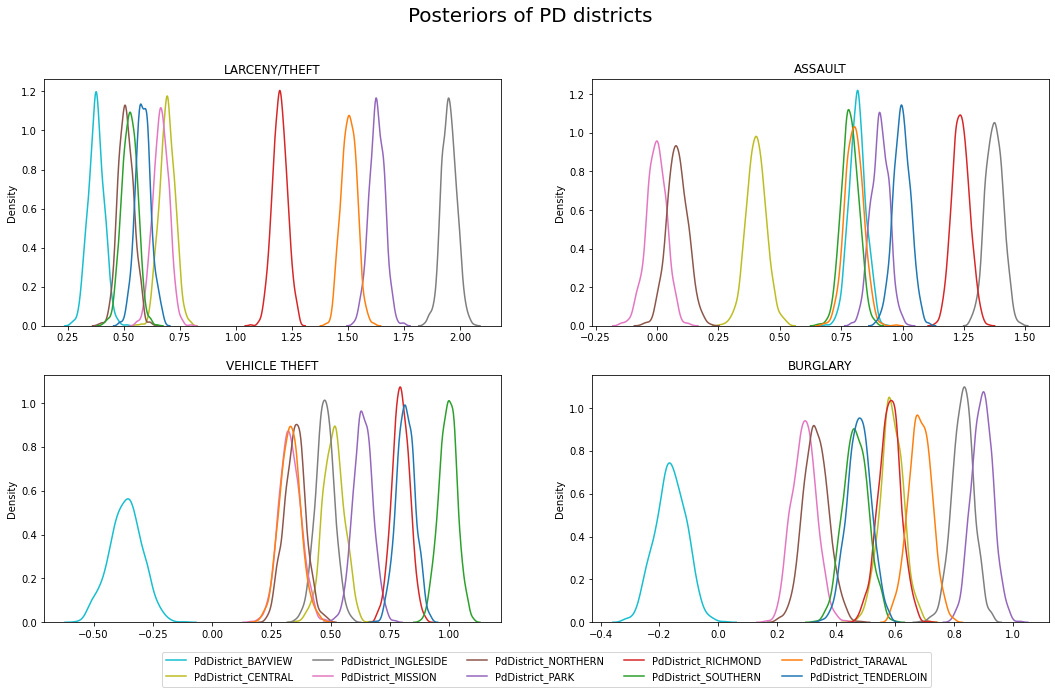

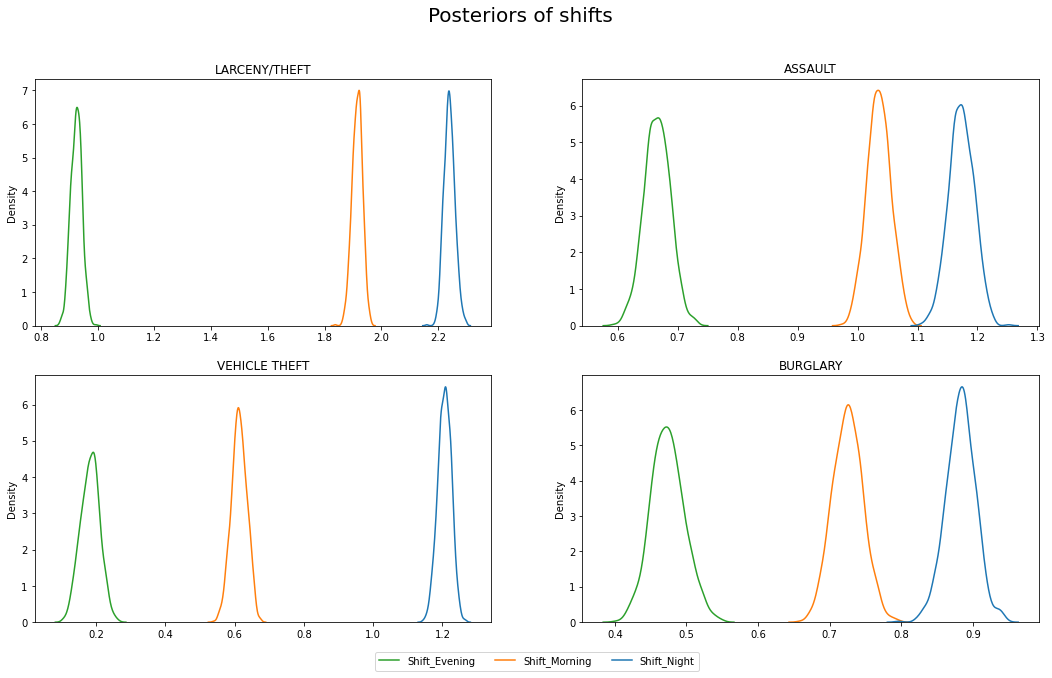

In [ ]:
def plot_pred_post(title, col_subset):
    fig = plt.figure(figsize=(18,10))
    fig.suptitle(title, fontsize=20)
    columns = df.drop(columns=["Category","Count"]).columns[col_subset]
    for c in range(n_crime):
        plotdata = pd.DataFrame(beta_samples[:,c,col_subset],columns=columns)
        ax = fig.add_subplot(2,2,c+1)
        ax.set_title(crime_cat_list[c])
        sns.kdeplot(ax=ax, data=plotdata,legend=False)
    plt.legend(columns, ncol=5, bbox_to_anchor=(-0.1, -0.1), loc="upper center")
    plt.show()

plot_pred_post("Posteriors of PD districts", range(0,10)) # PdDistricts
print()
plot_pred_post("Posteriors of shifts", range(10, 13)) # Shifts

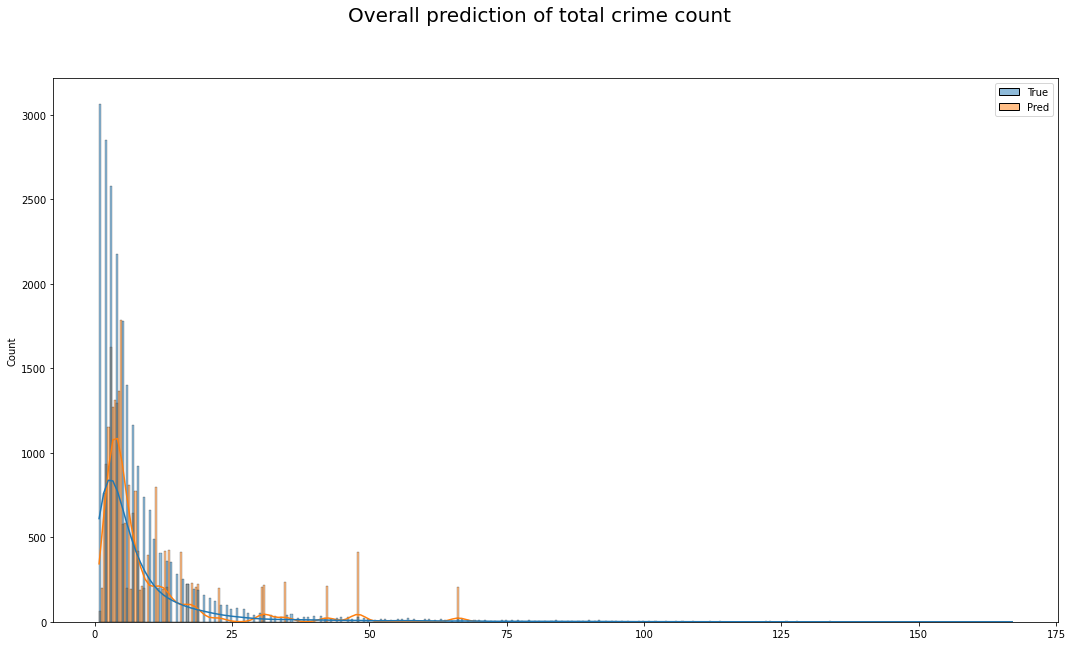

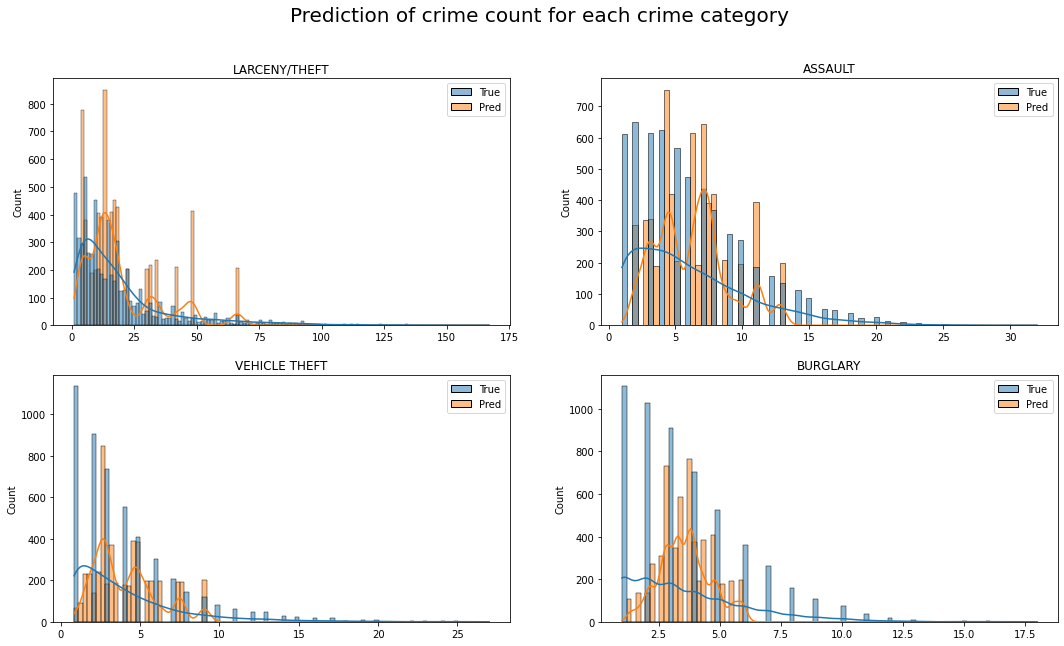

In [ ]:
r = np.matrix([y_test,y_hat]).T
r = pd.DataFrame(r, columns=["True", "Pred"])

fig,ax = plt.subplots(figsize=(18, 10))
fig.suptitle("Overall prediction of total crime count", fontsize=20)
sns.histplot(ax=ax, data=r, kde=True)
plt.show()

fig = plt.figure(figsize=(18, 10))
fig.suptitle("Prediction of crime count for each crime category", fontsize=20)
for c in range(n_crime):
    plotdata = r[crime_cat_test == c]
    ax = fig.add_subplot(2,2,c+1)
    ax.set_title(crime_cat_list[c])
    sns.histplot(ax=ax, data=plotdata, kde=True)
plt.show()

We observe no improvement of the model. This can likely be explained by the poisson distribution already reaching the limit of information that can be inferred from our limited features given the current model.

Our next step would be to take a step back and redefine the model.

# Model #5: Make crime categories into features

We will attempt a new model where each crime category is a feature and we only have a single set of beta-values. Essentially, this means we now have a single regression model.

In [ ]:
# One-hot encode crime categories
df2 = pd.get_dummies(df, columns=["Category"])
df2

,Count,PdDistrict_BAYVIEW,PdDistrict_CENTRAL,PdDistrict_INGLESIDE,PdDistrict_MISSION,PdDistrict_NORTHERN,PdDistrict_PARK,PdDistrict_RICHMOND,PdDistrict_SOUTHERN,PdDistrict_TARAVAL,PdDistrict_TENDERLOIN,Shift_Evening,Shift_Morning,Shift_Night,Category_0,Category_1,Category_2,Category_3
0,12,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
1,14,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
2,4,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
3,20,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
4,14,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55465,2,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1
55466,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1
55467,2,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1
55468,2,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1


In [ ]:
# Split data into features and target values
X = df2.drop(columns=["Count"]).values
y = df2["Count"].values

n_feats = X.shape[1] # Number of features

# Split into training and test data sets
train_perc = 0.60 # percentage of training data
split_point = int(train_perc*len(y))
perm = np.random.permutation(len(y))
ix_train = perm[:split_point]
ix_test = perm[split_point:]

X_train = X[ix_train,:]
X_test = X[ix_test,:]

y_train = y[ix_train]
y_test = y[ix_test]

# Prepare data for Pyro model
X_train_torch = torch.tensor(X_train).float()
y_train_torch = torch.tensor(y_train).float()

print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

num train: 33282
num test: 22188


In [ ]:
def model(X, n_feats, obs=None):
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(n_feats), torch.ones(n_feats)).to_event())
    with pyro.plate("data", X.shape[0]):
        y = pyro.sample("y", dist.Poisson(torch.exp(X.matmul(beta.T))), obs=obs)
    return y

In [ ]:
# Define guide function
guide = AutoDiagonalNormal(model)
# Define the number of optimization steps
n_steps = 10000
# Setup the inference algorithm
pyro.clear_param_store()
svi = SVI(model, guide, ClippedAdam({"lr": 0.001}), Trace_ELBO())

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_torch, n_feats, y_train_torch)
    if step == 0 or (step+1) % 2500 == 0:
        print("[%d] ELBO: %.1f" % (step+1, elbo))

[1] ELBO: 549728.1
[2500] ELBO: 116712.3
[5000] ELBO: 116066.9
[7500] ELBO: 116067.7
[10000] ELBO: 116069.6


In [ ]:
predictive = Predictive(model, guide=guide, num_samples=1000,return_sites=("beta",))
samples = predictive(X_train_torch, n_feats)

In [ ]:
beta_samples = samples["beta"].detach().numpy()
beta_hat = np.mean(beta_samples[:,0,:], axis=0)

y_hat = np.exp(np.dot(X_train,beta_hat))

err_1 = compute_error(y_train, y_hat)

# Now assess error on test data
y_hat = np.exp(np.dot(X_test,beta_hat))

err_2 = compute_error(y_test, y_hat)

pd.DataFrame(np.round([err_1, err_2], 2), ["Training set", "Test set"], ["CorrCoef", "MAE", "RAE", "RMSE", "R2"])

,CorrCoef,MAE,RAE,RMSE,R2
Training set,0.8,4.37,0.59,7.93,0.64
Test set,0.8,4.27,0.59,7.69,0.64


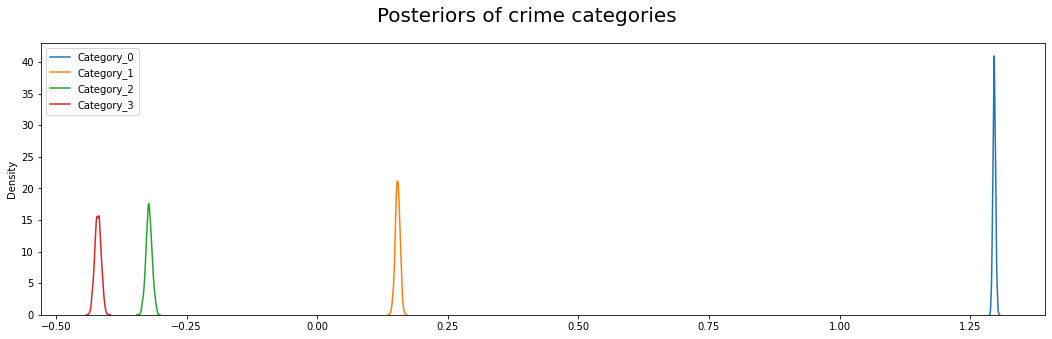

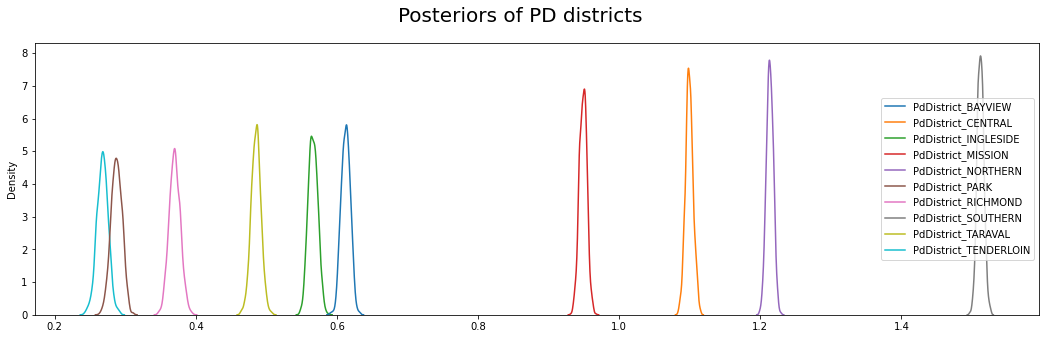

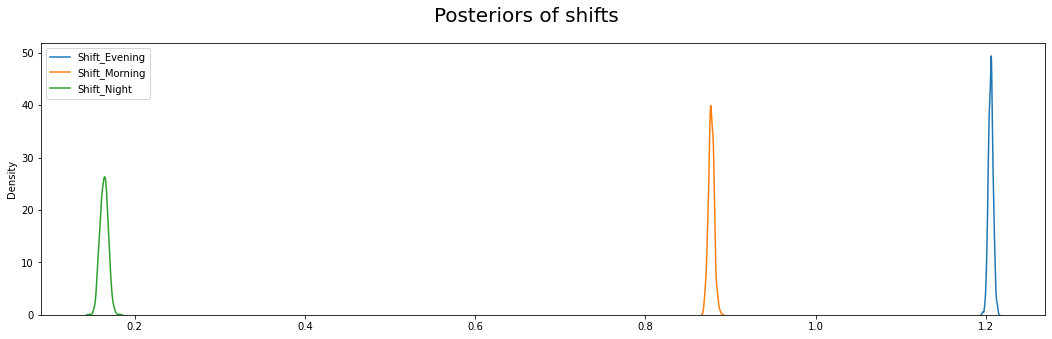

In [ ]:
def plot_pred_post(title, col_subset):
    fig,ax = plt.subplots(figsize=(18,5))
    fig.suptitle(title, fontsize=20)
    columns = df2.drop(columns=["Count"]).columns[col_subset]
    plotdata = pd.DataFrame(beta_samples[:,0,col_subset],columns=columns)
    sns.kdeplot(ax=ax, data=plotdata)
    plt.show()

plot_pred_post("Posteriors of crime categories", range(13,17))
plot_pred_post("Posteriors of PD districts", range(0,10))
plot_pred_post("Posteriors of shifts", range(10, 13))

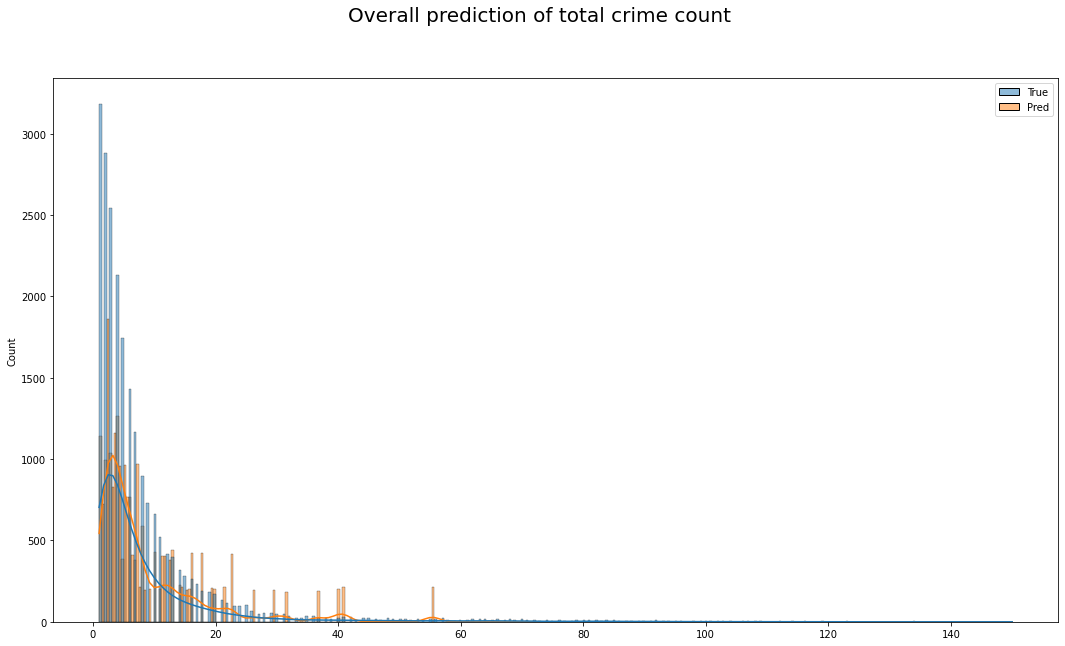

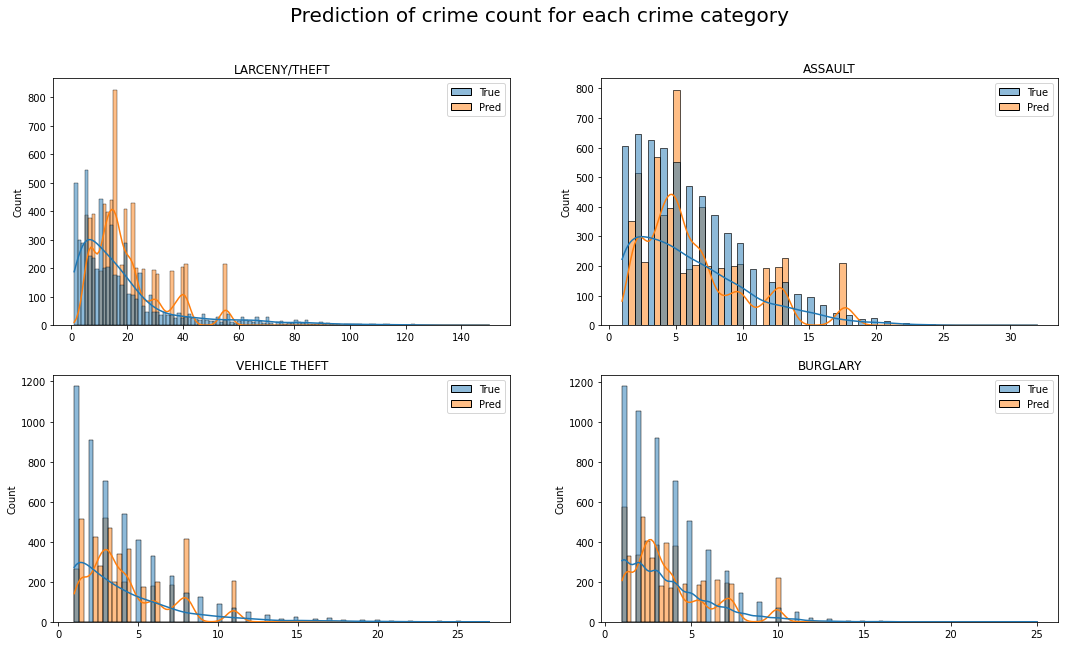

In [ ]:
r = np.matrix([y_test,y_hat]).T
r = pd.DataFrame(r, columns=["True", "Pred"])

fig,ax = plt.subplots(figsize=(18, 10))
fig.suptitle("Overall prediction of total crime count", fontsize=20)
sns.histplot(ax=ax, data=r, kde=True)
plt.show()

fig = plt.figure(figsize=(18, 10))
fig.suptitle("Prediction of crime count for each crime category", fontsize=20)
for c in range(n_crime):
    plotdata = r[X_test[:,13+c] == 1]
    ax = fig.add_subplot(2,2,c+1)
    ax.set_title(crime_cat_list[c])
    sns.histplot(ax=ax, data=plotdata, kde=True)
plt.show()

It would seem seems that making the crime categories into features, have made a significant difference. Despite the R2-values being lower than the preceding model (down from 0.78), the mode of the predicted total crime count has moved closer to the mode of the true distribution. Also, the shapes of the predicted crime distributions have improved.

To develop further on this finding, we will attempt non-linear regression.

# Model #6: Non-linear regression

To model non-linear relationships between features, we will implement a neural network.

In [ ]:
class BayesianRegression(PyroModule):
    def __init__(self, in_features, n_hidden, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Sequential](
            PyroModule[nn.Linear](in_features, n_hidden),
            PyroModule[nn.Tanh](),
            PyroModule[nn.Linear](n_hidden, n_hidden),
            PyroModule[nn.Tanh](),
            PyroModule[nn.Linear](n_hidden, n_hidden),
            PyroModule[nn.Tanh](),
            PyroModule[nn.Linear](n_hidden, out_features),
        )

    def forward(self, X, y=None):
        mean = self.linear(X).squeeze(-1)
        with pyro.plate("data", X.shape[0]):
            obs = pyro.sample("obs", dist.Poisson(torch.exp(mean)), obs=y)
        return mean

model = BayesianRegression(n_feats, 5, 1)
for m in model.modules():
    for name, value in list(m.named_parameters(recurse=False)):
        print(name)
        setattr(m, name, PyroSample(prior=dist.Normal(0, 1)
                                              .expand(value.shape)
                                              .to_event(value.dim())))

weight
bias
weight
bias
weight
bias
weight
bias


In [ ]:
# Define guide function
guide = AutoDiagonalNormal(model)
# Define the number of optimization steps
n_steps = 10000
# Setup the inference algorithm
pyro.clear_param_store()
svi = SVI(model, guide, ClippedAdam({"lr": 0.001}), Trace_ELBO())

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_torch, y_train_torch)
    if step == 0 or (step+1) % 2500 == 0:
        print("[%d] ELBO: %.1f" % (step+1, elbo))

[1] ELBO: 466416.6
[2500] ELBO: 116734.8
[5000] ELBO: 111270.7
[7500] ELBO: 104118.9
[10000] ELBO: 106342.0


In [ ]:
predictive = Predictive(model, guide=guide, num_samples=1000, return_sites=("obs",))

samples = predictive(X_train_torch)
y_hat = samples["obs"].mean(axis=0).detach().numpy()
err_1 = compute_error(y_train, y_hat)

samples = predictive(torch.tensor(X_test).float())
y_hat = samples["obs"].mean(axis=0).detach().numpy()
err_2 = compute_error(y_test, y_hat)

pd.DataFrame(np.round([err_1, err_2], 2), ["Training set", "Test set"], ["CorrCoef", "MAE", "RAE", "RMSE", "R2"])

,CorrCoef,MAE,RAE,RMSE,R2
Training set,0.84,3.84,0.51,7.23,0.7
Test set,0.84,3.75,0.52,7.03,0.7


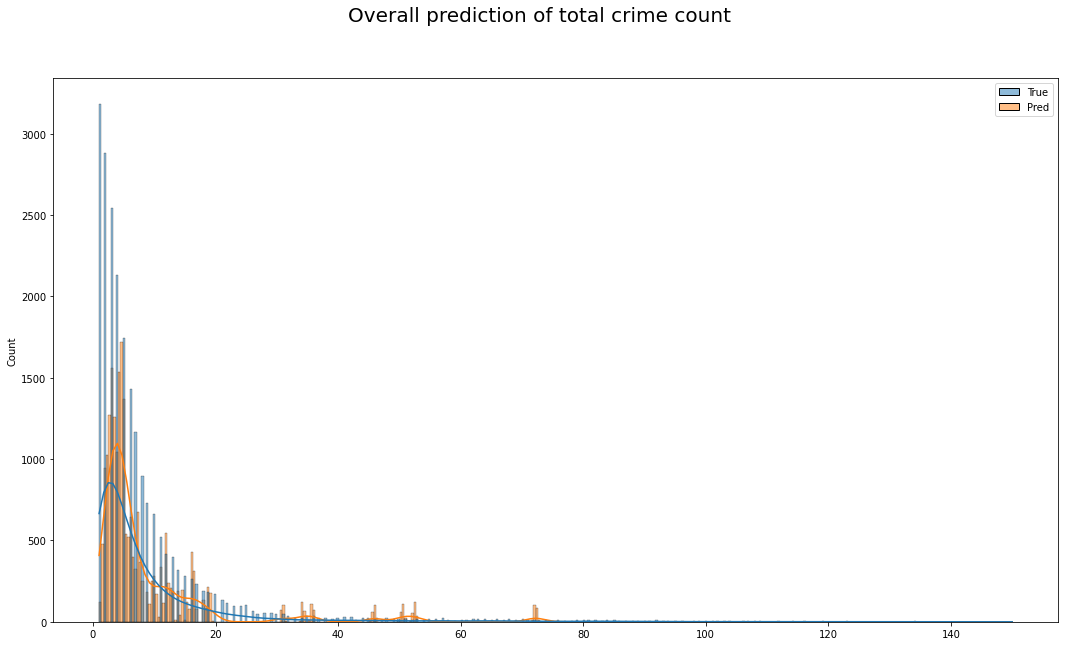

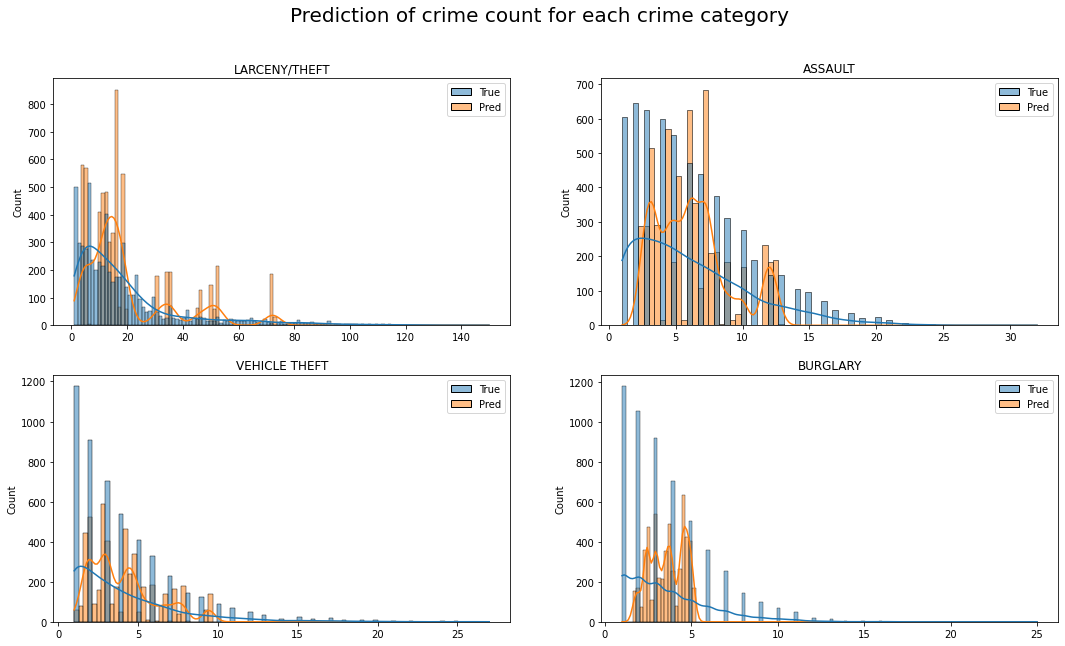

In [ ]:
r = np.matrix([y_test,y_hat]).T
r = pd.DataFrame(r, columns=["True", "Pred"])

fig,ax = plt.subplots(figsize=(18, 10))
fig.suptitle("Overall prediction of total crime count", fontsize=20)
sns.histplot(ax=ax, data=r, kde=True)
plt.show()

fig = plt.figure(figsize=(18, 10))
fig.suptitle("Prediction of crime count for each crime category", fontsize=20)
for c in range(n_crime):
    plotdata = r[X_test[:,13+c] == 1]
    ax = fig.add_subplot(2,2,c+1)
    ax.set_title(crime_cat_list[c])
    sns.histplot(ax=ax, data=plotdata, kde=True)
plt.show()

We observe improved results by using a non-linear model. However, the results are almost identical to the ones from Model #3. For this reason, we will use Model #3 going forward because it is a simpler linear regression model.

# Application of selected model

The initial idea of developing this model was for employee schedule planning. For instance, in a given week, how many police officers should be placed in a given PD district and on which kinds of shifts.

We will give an example of this below.

In [ ]:
# Generate a matrix for crime forecasting over every PD district and shift
data = []
for PDD in range(0,10):
    # Make a row for all features (10+3) and
    # crime category (1 column containg 0, 1, 2 or 3)
    a = np.zeros(14, dtype=float)
    # Set PD district
    a[PDD] = 1
    for Shift in range(10,13):
        b = a.copy()
        # Set shift
        b[Shift] = 1
        for Crime in range(0,4):
            c = b.copy()
            # Set crime category in last column
            c[13] = Crime
            data.append(c)
data = np.array(data)
print(data.shape) # 12 rows per PD district (of which there are 10)
data

(120, 14)


array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 2.],
       ...,
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 1., 2.],
       [0., 0., 0., ..., 0., 1., 3.]])

In [ ]:
# Split data into features and crime categories
X_data = data[:,0:13]
crime_cat = data[:,13].astype(int)

# Get beta samples from Model #3
beta_samples = samples3["beta"].detach().numpy()

prod_diag = np.einsum("ij,kij->ik", X_data, beta_samples[:,crime_cat,:], optimize=True)
forecast = np.mean(np.exp(prod_diag), axis=1) # Number of crimes corresponding to X and crime_cat

# Reshape forecasted data into a matrix and sum crime counts for each shift
expected_crime = forecast.reshape(10,3,4).sum(axis=2)

# Normalize crime counts to get percentages
expected_crime = expected_crime/expected_crime.sum()

officers_avail = 50 # Officers available in a given week
shift_num = 5 # Number of shifts that an officer works in a given week
shift_total = officers_avail*shift_num # Total number of working shifts during a week

# Get officers per PD district and shift
officer_dist = expected_crime*shift_total

# Get features labels
labels = df.drop(columns=["Category","Count"]).columns
labels = np.array([x.split("_")[1] for x in labels])

# Make a pretty table
pd.DataFrame(np.round(officer_dist, decimals=2), labels[0:10], labels[10:13])

,Evening,Morning,Night
BAYVIEW,9.66,6.95,3.85
CENTRAL,15.87,11.39,5.31
INGLESIDE,9.28,6.53,3.63
MISSION,13.59,9.81,5.10
NORTHERN,17.94,12.84,6.08
PARK,7.09,5.04,2.60
RICHMOND,7.83,5.53,2.74
SOUTHERN,23.99,17.32,8.01
TARAVAL,8.65,6.18,3.24
TENDERLOIN,6.52,4.86,2.58


The table above shows how many shifts should be covered during the week, if we assume that each crime category will occur in every PD district during every shift of the week. For example, SOUTHERN should have officers covering 8 night shifts every week, according to the forecast.

The results should only be used as a guide. Other factors are relevant in actual timetabling of the police officers, e.g. consecutive working days and distance between PD districts so officers can cover multiple districts in a single shift.